# 2-D Cahn–Hilliard with Continuation

This notebook simulates the 2-D Cahn-Hilliard equation, a model for phase separation in binary mixtures. It uses a Fourier spectral discretization and a semi-implicit time-stepping scheme. The main feature is a simple continuation in the quench parameter $\alpha$, where the steady state from one parameter value is used as the initial condition for the next.

The equation is:
$$
\partial_t c = M \nabla^2 \big(f'(c) - \epsilon^2 \nabla^2 c\big)
$$
on a periodic square domain.

In [1]:
import numpy as np
from numpy.fft import fft2, ifft2, fftfreq
import matplotlib.pyplot as plt

np.random.seed(7)
plt.rcParams.update({"figure.figsize": (6, 4), "image.cmap": "RdBu_r"})

### Physical parameters and continuation path
Define the physical and numerical parameters for the simulation:
- `M`: Mobility.
- `epsilon`: Interface width parameter.
- `L`: Domain size.
- `Nx`, `Ny`: Grid resolution.
- `dt`: Time step size.
- `alphas`: The range of the quench parameter for continuation.

In [2]:
M = 1.0          # mobility
epsilon = 0.02   # interface width
L = 1.0          # domain length in each direction
Nx = Ny = 64     # grid points per dimension (keep modest)
dt = 5e-4        # time step
steps_per_alpha = 300
alphas = np.linspace(-0.2, 0.2, 9)  # continuation in quench depth (more points for snapshots)

### Spatial grid and spectral operators
Set up the computational grid and the wavenumbers for the Fourier spectral method. A 2/3 dealiasing rule is applied to mitigate aliasing errors from the nonlinear term.

In [3]:
x = np.linspace(0, L, Nx, endpoint=False)
y = np.linspace(0, L, Ny, endpoint=False)
X, Y = np.meshgrid(x, y, indexing="ij")

kx = 2 * np.pi * fftfreq(Nx, d=L / Nx)
ky = 2 * np.pi * fftfreq(Ny, d=L / Ny)
KX, KY = np.meshgrid(kx, ky, indexing="ij")
k2 = KX ** 2 + KY ** 2
k4 = k2 ** 2

# 2/3 dealiasing mask
kx_cut = (2.0 / 3.0) * np.max(np.abs(kx))
ky_cut = (2.0 / 3.0) * np.max(np.abs(ky))
mask = (np.abs(KX) <= kx_cut) & (np.abs(KY) <= ky_cut)

### Initial condition
The simulation starts with a constant mean concentration plus small random noise. The `enforce_mean` function ensures that the mean concentration is conserved throughout the simulation.

In [4]:
mean_c = -0.1
target_mean = mean_c
noise_level = 0.02
c0 = mean_c + noise_level * (np.random.rand(Nx, Ny) - 0.5)

def enforce_mean(field, target=0.0):
    return field + (target - np.mean(field))

c = enforce_mean(c0, target_mean)

### Free energy density and chemical potential helpers
Helper functions to compute the free energy density $f(c, \alpha)$, its derivative $f'(c, \alpha)$, and the total free energy of the system. The `mass` function computes the mean concentration.

In [5]:
def f(c, alpha):
    return 0.25 * (c**2 - 1.0) ** 2 + alpha * c

def fprime(c, alpha):
    return c**3 - c + alpha

def free_energy(c, alpha):
    c_hat = fft2(c)
    grad_c_hat = 1j * np.stack([KX * c_hat, KY * c_hat])
    grad_sq = np.real(np.sum(np.abs(grad_c_hat) ** 2, axis=0))
    bulk = f(c, alpha)
    return np.mean(bulk + 0.5 * epsilon**2 * grad_sq)

def mass(c):
    return np.mean(c)

### Semi-implicit Fourier spectral stepper with dealiasing
The `step` function performs a single time step of the simulation using a semi-implicit Euler method in Fourier space. The linear terms are treated implicitly for stability, while the nonlinear term is treated explicitly and dealiased.

In [6]:
def dealiase(hat_field):
    return hat_field * mask

def step(c, alpha, target=0.0):
    c_hat = fft2(c)
    nonlinear_hat = fft2(fprime(c, alpha))
    nonlinear_hat = dealiase(nonlinear_hat)
    denom = 1.0 + dt * M * epsilon**2 * k4
    numer = c_hat - dt * M * k2 * nonlinear_hat
    c_hat_new = numer / denom
    c_new = np.real(ifft2(c_hat_new))
    return enforce_mean(c_new, target)

### Continuation loop over alpha
This is the main loop for the continuation. For each value of $\alpha$ in `alphas`, the system is evolved for a fixed number of steps to reach a steady state. The final state, energy, and mass are recorded for each $\alpha$.

In [7]:
energies = []
masses = []
fields = []

c_current = c.copy()
for alpha in alphas:
    for _ in range(steps_per_alpha):
        c_current = step(c_current, alpha, target_mean)
    energies.append(free_energy(c_current, alpha))
    masses.append(mass(c_current))
    fields.append(c_current.copy())
    print(f"alpha={alpha:+.3f} mass={masses[-1]:+.4e} F={energies[-1]:.4e}")

alpha=-0.200 mass=-1.0000e-01 F=1.9536e+02
alpha=-0.150 mass=-1.0000e-01 F=1.5515e+02
alpha=-0.100 mass=-1.0000e-01 F=1.1910e+02
alpha=-0.050 mass=-1.0000e-01 F=1.0180e+02
alpha=+0.000 mass=-1.0000e-01 F=9.6344e+01
alpha=+0.050 mass=-1.0000e-01 F=9.4134e+01
alpha=+0.100 mass=-1.0000e-01 F=9.2955e+01
alpha=+0.150 mass=-1.0000e-01 F=9.2233e+01
alpha=+0.200 mass=-1.0000e-01 F=9.1760e+01


### Visualization of continuation snapshots and diagnostics
The results are visualized by plotting snapshots of the concentration field at different values of $\alpha$ and by plotting the free energy and mass as a function of $\alpha$.

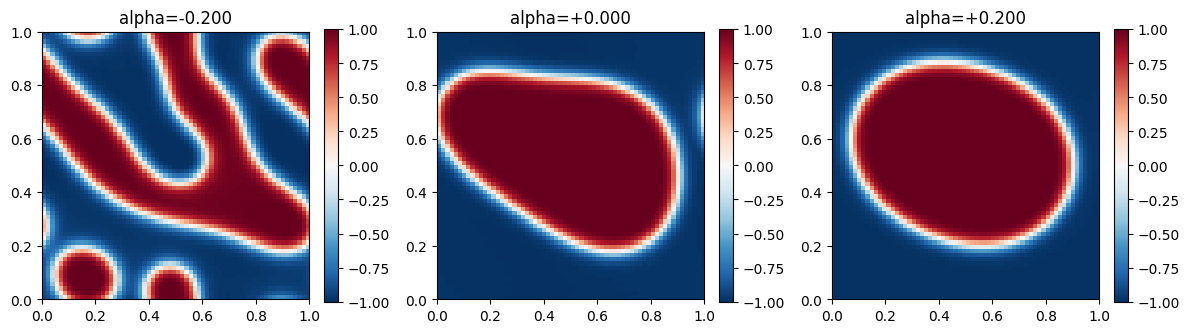

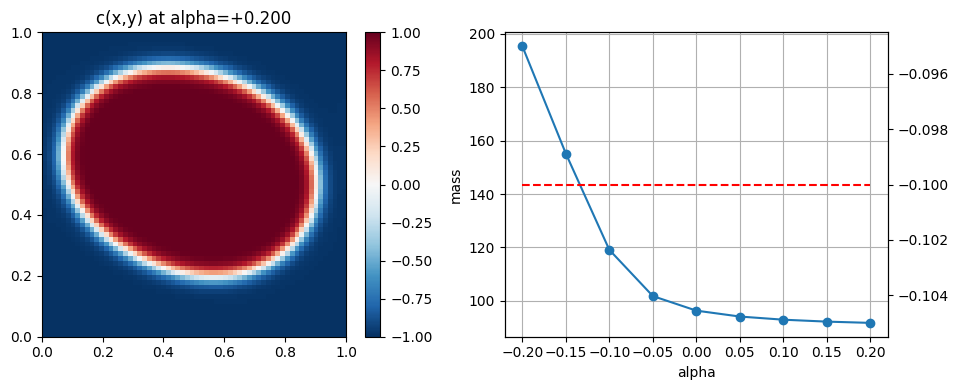

In [8]:
last_field = fields[-1]

# Sample a handful of states along the continuation to see how patterns evolve
n_snap = min(3, len(fields))
snap_indices = np.linspace(0, len(fields) - 1, n_snap, dtype=int)
fig, axes = plt.subplots(nrows=int(np.ceil(n_snap / 3)), ncols=3, figsize=(12, 4 * int(np.ceil(n_snap / 3))))
axes = np.array(axes).reshape(-1)
for ax, idx in zip(axes, snap_indices):
    im = ax.imshow(fields[idx], origin="lower", extent=(0, L, 0, L), vmin=-1, vmax=1)
    ax.set_title(f"alpha={alphas[idx]:+.3f}")
    fig.colorbar(im, ax=ax, fraction=0.046)
for ax in axes[len(snap_indices):]:
    ax.axis("off")
fig.tight_layout()
plt.show()

# Final state and scalar diagnostics
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
im = ax[0].imshow(last_field, origin="lower", extent=(0, L, 0, L), vmin=-1, vmax=1)
ax[0].set_title(f"c(x,y) at alpha={alphas[-1]:+.3f}")
fig.colorbar(im, ax=ax[0], fraction=0.046)

ax[1].plot(alphas, energies, marker="o", label="Free energy")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("F/N")
ax[1].grid(True)
ax[1].twinx().plot(alphas, masses, "r--", label="mass")
ax[1].set_ylabel("mass")
fig.tight_layout()
plt.show()

## Optional: sweep mean concentration at fixed $\alpha=0$
This optional section demonstrates how the pattern formation depends on the mean concentration $\bar{c}$. The simulation is run for a range of mean concentrations at a fixed $\alpha=0$. This illustrates the transition from stable uniform states to pattern-forming states within the spinodal region.

mean_c=-0.200 mass=-2.0000e-01 F=1.8707e+02
mean_c=-0.150 mass=-1.5000e-01 F=1.9014e+02
mean_c=-0.100 mass=-1.0000e-01 F=1.8277e+02
mean_c=-0.050 mass=-5.0000e-02 F=2.0992e+02
mean_c=+0.000 mass=-1.3878e-17 F=2.0218e+02
mean_c=+0.050 mass=+5.0000e-02 F=1.9180e+02
mean_c=+0.100 mass=+1.0000e-01 F=1.7679e+02
mean_c=+0.150 mass=+1.5000e-01 F=1.9857e+02
mean_c=+0.200 mass=+2.0000e-01 F=1.9784e+02


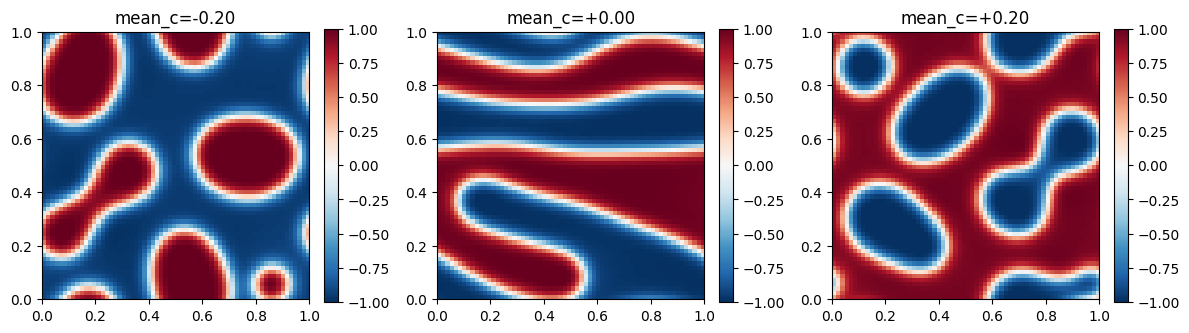

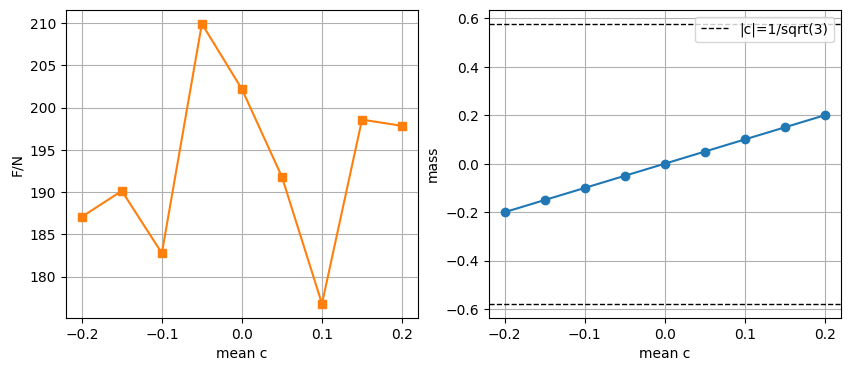

In [9]:
mean_cs = np.linspace(-0.2, 0.2, 9)
steps_per_mean = 300
alpha_fixed = 0.0
spinodal_thresh = 1 / np.sqrt(3)

mean_fields = []
mean_energies = []
mean_masses = []

for mc in mean_cs:
    c_mc = enforce_mean(mc + noise_level * (np.random.rand(Nx, Ny) - 0.5), mc)
    for _ in range(steps_per_mean):
        c_mc = step(c_mc, alpha_fixed, target=mc)
    mean_fields.append(c_mc)
    mean_energies.append(free_energy(c_mc, alpha_fixed))
    mean_masses.append(mass(c_mc))
    print(f"mean_c={mc:+.3f} mass={mean_masses[-1]:+.4e} F={mean_energies[-1]:.4e}")

# Diagnostics and a few snapshots
fig, axes = plt.subplots(1, 3, figsize=(12, 7))
axes = axes.ravel()
picks = [0, len(mean_cs) // 2, -1]
for ax, idx in zip(axes[:3], picks):
    im = ax.imshow(mean_fields[idx], origin="lower", extent=(0, L, 0, L), vmin=-1, vmax=1)
    ax.set_title(f"mean_c={mean_cs[idx]:+.2f}")
    fig.colorbar(im, ax=ax, fraction=0.046)

fig.tight_layout()
plt.show()

fig2, axes2 = plt.subplots(1, 2, figsize=(10, 4))
axes2[1].plot(mean_cs, mean_masses, marker="o")
axes2[1].axhline(+spinodal_thresh, color="k", ls="--", lw=1, label="|c|=1/sqrt(3)")
axes2[1].axhline(-spinodal_thresh, color="k", ls="--", lw=1)
axes2[1].set_xlabel("mean c")
axes2[1].set_ylabel("mass")
axes2[1].grid(True)
axes2[1].legend()

axes2[0].plot(mean_cs, mean_energies, marker="s", color="tab:orange")
axes2[0].set_xlabel("mean c")
axes2[0].set_ylabel("F/N")
axes2[0].grid(True)

# axes2[0].axis("off")